The first things we have to consider in order to calculate quantum volume is the amount of qubits and which ones we'll use. This amount of qubits will equal not only the width of the circuit but also de depth. 

In [1]:
# create a list with the qubits we want to use
qubit_list = [i for i in range(5)]

# save the length of the list = number of qubits = depth of the circuits = width of the circuits
SIZE = len(qubit_list)

In order to measure quantum volume, we'll need to create random 2-qubit gates. That can be easily done with the `random_unitary` function from `qiskit.quantum_info`.

In [2]:
from qiskit.quantum_info import random_unitary
# create a random 4x4 unitary matrix i.e. a random 2-qubit operator
random_unitary(4)

Operator([[ 0.00441681-0.55516839j, -0.15735451+0.55681241j,
           -0.35048687+0.40976387j,  0.10176567-0.23635636j],
          [-0.27265002-0.50349559j,  0.37275292-0.06444231j,
           -0.13597816-0.650909j  ,  0.29388431-0.0227163j ],
          [-0.56624062-0.04478311j, -0.5206927 +0.08666439j,
            0.16889374+0.0263565j ,  0.25650121+0.5511096j ],
          [-0.20311245-0.00583789j, -0.43991748+0.22347921j,
            0.20450858-0.44276j   , -0.51323452-0.46257007j]],
         input_dims=(2, 2), output_dims=(2, 2))

Now that we have the needed gates, let's start by using them with pairs of adjacent qubits. If we have an odd number of qubits, one of them will be left alone.

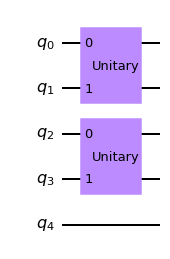

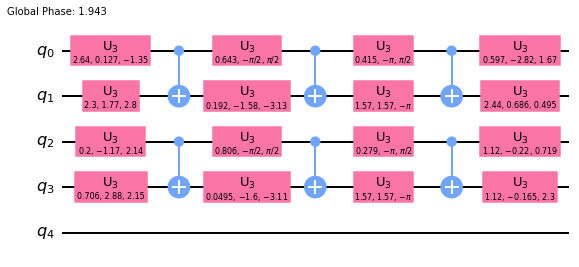

In [3]:
from qiskit import QuantumCircuit

# create the circuit corresponding to the first layer
qv_layer = QuantumCircuit(SIZE)

# iterate over the pairs of qubits, of which there are SIZE/2
for pair in range(SIZE//2):
    # choose indexes
    qubit_indices = qubit_list[pair * 2 : pair * 2 + 2]
    # create gate
    gate = random_unitary(2 * (SIZE//2)).to_instruction()
    # add gate to circuit
    qv_layer.append(gate, qubit_indices)

# show the layer circuit
display(qv_layer.draw("mpl"))

# show a more detailed version of the layer circuit
display(qv_layer.decompose().draw("mpl"))

The next step will be creating a circuit with `SIZE` layers instead of only one. Before each layer we have to randomly permutate the qubits, what can be done with the `shuffle` function from `random`. 

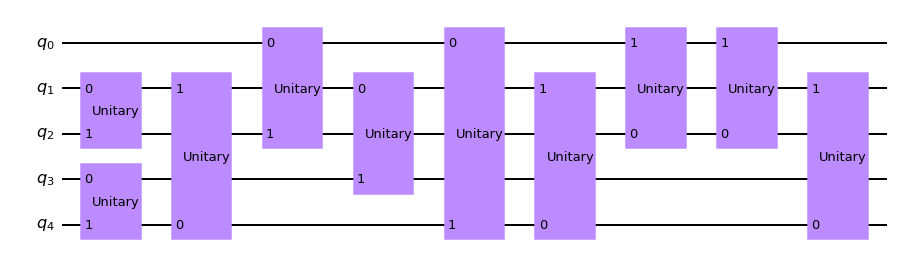

In [4]:
from random import shuffle

qlist = qubit_list[:]

# create the circuit
qv_circ = QuantumCircuit(SIZE)

# randomly permutate the list of qubits and add a layer SIZE = depth times
for i in range(SIZE):
    shuffle(qlist)
    for pair in range(SIZE//2):
        qubit_indices = qlist[pair * 2 : pair * 2 + 2]
        gate = random_unitary(2 * (SIZE//2)).to_instruction()
        qv_circ.append(gate, qubit_indices)

#show the circuit
display(qv_circ.draw("mpl"))


Now we'll use the simulator `aer_simulator` from `Aer` to obtain the ideal probability distribution of the outputs of our circuit. In other words, we'll see what we should get if we ran our circuit with an ideal quantum computer.

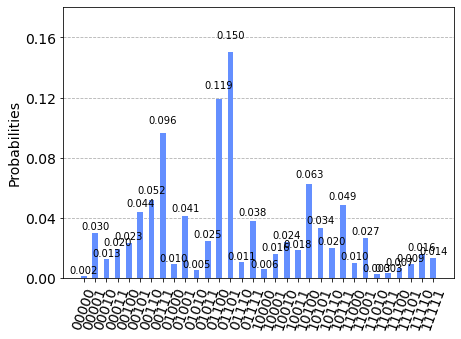

In [5]:
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram

# define the simulator
simulator = Aer.get_backend("aer_simulator")

# transpile the circuit so it can be used with the simulator
t_qv_circ = transpile(qv_circ, simulator)

# save the statevector of the circuit
t_qv_circ.save_statevector()

# run the simulator to get the probability distribution
counts = simulator.run(t_qv_circ).result().get_counts()

# represent the probability distribution with an histogram
plot_histogram(counts)

The part of the probability distribution that will be interesting to us is the heavy outputs, the outputs whose probability is higher than the median's. We can select these values by ordering our list of outputs by probability with `sorted` and then selecting the second half of the indices.

In [6]:
# sort the list of outputs by probability
sorted_counts = sorted(counts.keys(), key = counts.get)

# pick the heavy outputs
heavy_outputs = sorted_counts[len(sorted_counts)//2 : ]

# show the heavy outputs
print(heavy_outputs)

['10110', '00100', '10010', '01011', '11001', '00001', '10101', '01111', '01001', '00101', '10111', '00110', '10100', '00111', '01100', '01101']


After getting our heavy output list it's time to think about running our circuit with an actual quantum computer. One way of doing this is by using Qiskit Runtime. For this purpose we start by creating a `QiskitRuntimeService` instance. 

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService

# create the QiskitRuntimeService instance
service = QiskitRuntimeService(channel="ibm_quantum")

Let's see what quantum systems we can have access to.

In [8]:
# show backends
service.backends()

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_armonk')>,
 <IBMBackend('ibmq_montreal')>,
 <IBMBackend('ibmq_toronto')>,
 <IBMBackend('ibmq_bogota')>,
 <IBMBackend('ibmq_kolkata')>,
 <IBMBackend('ibmq_mumbai')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('ibmq_guadalupe')>,
 <IBMBackend('ibmq_brooklyn')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_hanoi')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_cairo')>,
 <IBMBackend('ibm_auckland')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibm_washington')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_oslo')>]

In order to use a quantum computer, for example `ibmq_toronto`, we will create a `Sampler` instance. The Sampler will use the account loaded in the `QiskitRuntimeService` instance to access the selected backend (in this case `ibmq_toronto`) and run the circuits of our choosing (`qv_circ`) as many times as we wish. For this example we'll run the circuit `nshots` = 1024 times. It's important to note that before running our circuit, it has to be traspiled according to the device we choose. In other words, we have to make the circuit compatible with our quantum computer. Generally, the `Sampler` does it for us unless we set the parameter `skip_transpilation` to `True`. However, given that we'll be interested in selecting specific qubit sequences, we have to transpile the circuit manually.

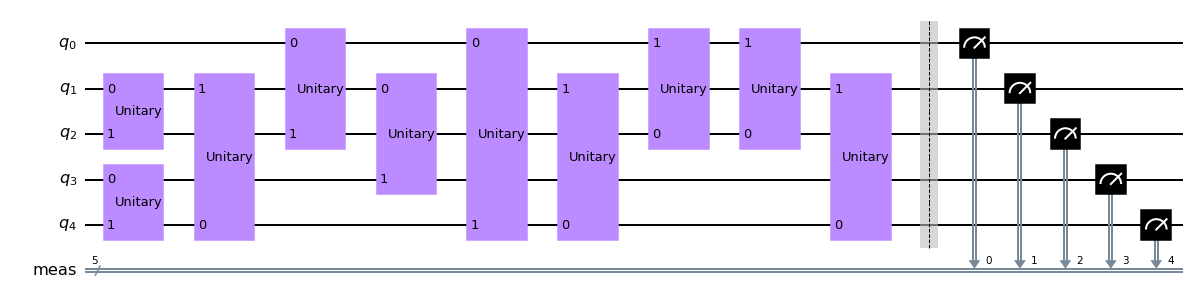

SamplerResult(quasi_dists=[{'00000': 0.05078125, '00001': 0.033203125, '10000': 0.025390625, '10001': 0.025390625, '10010': 0.052734375, '10011': 0.0263671875, '10100': 0.0283203125, '10101': 0.0400390625, '10110': 0.0263671875, '10111': 0.041015625, '11000': 0.0263671875, '11001': 0.0185546875, '11010': 0.015625, '11011': 0.013671875, '11100': 0.021484375, '11101': 0.0263671875, '11110': 0.0234375, '11111': 0.0244140625, '00010': 0.0361328125, '00011': 0.0263671875, '00100': 0.0302734375, '00101': 0.09375, '00110': 0.0205078125, '00111': 0.0498046875, '01000': 0.0458984375, '01001': 0.02734375, '01010': 0.02734375, '01011': 0.015625, '01100': 0.0302734375, '01101': 0.0498046875, '01110': 0.01171875, '01111': 0.015625}], metadata=[{'header_metadata': {}, 'shots': 1024}])
After running the circuit 1024 times, we got 587 heavy outputs.


In [9]:
from qiskit_ibm_runtime import Sampler

nshots = 1024

# measure the circuit in order to get something meaningful from the quantum computer.
qv_circ.measure_all()

# show the circuit with the measures
display(qv_circ.draw("mpl"))

# choose backend
toronto = service.backend("ibmq_toronto")

# transpile the circuit according to the chosen backend
transpiled_qv_circ = transpile(qv_circ, toronto, initial_layout = [1,3,4,10,21] )

# show transpiled circuit
# display(transpiled_qv_circ.draw("mpl"))

# create the Sampler instance
with Sampler(circuits = transpiled_qv_circ, service = service, skip_transpilation = True, options = { "backend": toronto }) as sampler:
    result = sampler(circuit_indices=[0], shots = nshots)
    print(result)

# take the results
device_counts = result.quasi_dists[0]

# initialize number of heavy outputs
nheavy = 0
# check if they are heavy outputs
for heavy_output in heavy_outputs:
    if heavy_output in device_counts.keys():
        nheavy += device_counts[heavy_output] * nshots
nheavy = int(nheavy)

print("After running the circuit", nshots, "times, we got", nheavy, "heavy outputs.")

Once we have obtained the number of heavy outputs for a particular circuit and combination of qubits, let's see how we can get all qubit combinations for a given size so we can directly check whether a quantum computer can achieve a determined Quantum Volume with a specific number of circuits and shots. One way of getting all the combinations of a given size from a given set is using `itertools.combinations`. This function gives us an iterable object.

In [10]:
import itertools
combinations_iterable = itertools.combinations(range(6), 5)
for combination in combinations_iterable:
    print(list(combination))

[0, 1, 2, 3, 4]
[0, 1, 2, 3, 5]
[0, 1, 2, 4, 5]
[0, 1, 3, 4, 5]
[0, 2, 3, 4, 5]
[1, 2, 3, 4, 5]


Finally let's put all of this together to evaluate more than 100 different circuits so we can have a valid measure of the quantum volume achieved with `ibmq_toronto`. It's important to note that a different choice of qubits can get different results so unless we try with all 5-qubit combinations we can't affirm that this computer doesn't have a quantum volume of $2^5 = 32$, only that these qubits may not be valid. It's also possible that the problem is not the choice of qubits but too few circuits.

In [11]:
from qiskit_ibm_runtime import Sampler, QiskitRuntimeService


def QV(size, backend, ncircuits = 100, nshots = 1024, service = QiskitRuntimeService(channel="ibm_quantum")):
    from qiskit import Aer, transpile, QuantumCircuit

    from qiskit_ibm_runtime import Sampler, QiskitRuntimeService
    from qiskit.quantum_info import random_unitary

    from random import shuffle

    import numpy as np

    import itertools
    
    # create a qubit list with the first size qubits to create the circuits
    qubit_list = [i for i in range(size)]


    # open a QiskitRuntimeService instance to access the quantum computer
    service = QiskitRuntimeService(channel="ibm_quantum")

    # choose simulator
    simulator = Aer.get_backend("aer_simulator")

    # get the number of qubits of the device
    device_qubits = backend.num_qubits

    # set boolean variable that shows if the desired QV was achieved
    success = False


    for device_qlist in itertools.combinations(range(device_qubits), size):
        # initialize the number of heavy outputs
        nheavy = 0

        for circuit in range(ncircuits):
            qlist = qubit_list[:]

            # create the circuit
            qv_circ = QuantumCircuit(size)

            for i in range(size):
                # permutation layer
                shuffle(qlist)
                # for each pair of adjacent (after the permutation) qubits we add a random 2-qubit operator.
                for pair in range(size//2):
                    qubit_indices = qlist[pair * 2 : pair * 2 + 2]
                    gate = random_unitary(4).to_instruction()
                    qv_circ.append(gate, qubit_indices)
            # transpile circuit to use the simulator
            qv_circ_simulator = transpile(qv_circ, simulator)
            # save the statevector of the circuit
            qv_circ_simulator.save_statevector()
            # get probabilities
            counts = simulator.run(qv_circ_simulator).result().get_counts()
            # sort the results by probability
            sorted_counts = sorted(counts.keys(), key = counts.get)
            # pick the heavy outputs
            heavy_outputs = sorted_counts[len(sorted_counts)//2 : ]

            # measure the circuit before running it through the quantum computer
            qv_circ.measure_all()

            qv_circ_device = transpile(qv_circ, backend, initial_layout = list(device_qlist))

            # use the sampler primitive to access the quantum computer and run the circuit nshots times
            with Sampler(circuits = qv_circ, service=service, options={ "backend": backend }) as sampler:
                result = sampler(circuit_indices=[0], shots=nshots)
            # take the results
            device_counts = result.quasi_dists[0]
            # check if they are heavy outputs
            for heavy_output in heavy_outputs:
                if heavy_output in device_counts.keys():
                    nheavy += device_counts[heavy_output] * nshots

        nheavy = int(nheavy)

        

        # determine if the quantum volume is achieved
        if (nheavy - 2 * np.sqrt(nheavy * (nshots - nheavy / ncircuits)))/(nshots * ncircuits) > 2/3:
            success = True
            print("Success! QV of", 2**size, "achieved!")
            break
    if success == False:
        print("Failure!")  